# Online Retail II — Robust Data Cleaning Notebook (No LLM)

This notebook performs **end‑to‑end data cleaning** for the Online Retail II dataset to produce a high‑quality interactions table suitable for collaborative filtering and ranking models.

**What the notebook does**
1. Load & standardize columns (per sheet).
2. Remove **returns/credit notes**, negative quantities/prices, and missing IDs.
3. Normalize **text** fields (trim, whitespace collapse, Unicode normalization).
4. Remove **non‑product lines** (shipping/fees/adjustments/tests).
5. De‑duplicate and **aggregate duplicate invoice lines**.
6. Detect and handle **outliers** (prices/quantities/line amount) via IQR on log scale.
7. Optional **coverage filters**: drop ultra‑rare items and single‑event users (configurable).
8. Build **final interactions** with derived fields and a clean **item catalog**.
9. Save cleaned data and a **quality report** with counts removed at each step.


In [1]:
# --- Config
from pathlib import Path
import pandas as pd
import numpy as np
import unicodedata, re, json
from datetime import datetime

DATA_PATH = Path('../data/raw/online_retail_II.xlsx')   # change if running elsewhere
OUT_DIR = Path('../data/processed/online_retail_II/')  # change if running elsewhere
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Cleaning toggles / thresholds
KEEP_ONLY_POSITIVE_QTY = True
KEEP_ONLY_POSITIVE_PRICE = True
DROP_RETURNS_BY_INVOICE_PREFIX = True   # invoices starting with 'C'
DROP_DUPLICATE_ROWS = True

# Non-product removal rules (description patterns; case-insensitive)
NON_PRODUCT_PATTERNS = [
    r'POSTAGE', r'SHIPPING', r'CARRIAGE', r'DELIVERY',
    r'BANK CHARGES', r'AMAZON', r'DOTCOM', r'PACKING', r'ADJUST', r'DISCOUNT',
    r'SAMPLE', r'SAMPLES', r'CHECK', r'TEST', r'MANUAL', r'FEE', r'CHARGE'
]

# Outlier handling (IQR on log values)
HANDLE_OUTLIERS = True
WINSORIZE_INSTEAD_OF_DROP = False   # if False, drop; if True, cap to bounds
LOG_EPS = 1e-6
IQR_MULT = 3.0     # 3*IQR is conservative on log scale

# Coverage filters (optional; applied after core cleaning)
MIN_EVENTS_PER_USER = 2       # set 1 to keep all users
MIN_PURCHASES_PER_ITEM = 2    # set 1 to keep all items

# Randomness
SEED = 42
np.random.seed(SEED)

In [2]:
# --- Load Excel per sheet with selected columns
xls = pd.ExcelFile(DATA_PATH)
usecols = ['Invoice', 'InvoiceNo', 'Invoice Date', 'InvoiceDate', 'StockCode', 'Description', 'Quantity', 'Price', 'Customer ID', 'CustomerID', 'Country']
frames = []
for s in xls.sheet_names:
    df = pd.read_excel(DATA_PATH, sheet_name=s, usecols=lambda c: c in usecols)
    df['source_sheet'] = s
    frames.append(df)
raw = pd.concat(frames, ignore_index=True)

# Standardize column names
raw.columns = [c.strip().replace(' ', '_').replace('-', '_').lower() for c in raw.columns]
rename_map = {
    'invoice': 'invoice_no',
    'invoice_no': 'invoice_no',
    'invoice_date': 'invoice_date',
    'invoicedate': 'invoice_date',
    'stockcode': 'stock_code',
    'customer_id': 'customer_id',
    'description': 'description',
    'quantity': 'quantity',
    'price': 'price',
    'country': 'country'
}
for k, v in rename_map.items():
    if k in raw.columns:
        raw.rename(columns={k: v}, inplace=True)

# Parse types
raw['invoice_no'] = raw['invoice_no'].astype(str)
raw['invoice_date'] = pd.to_datetime(raw['invoice_date'], errors='coerce')
raw['customer_id'] = pd.to_numeric(raw['customer_id'], errors='coerce')

print('Loaded rows:', len(raw))
raw.head(3)

Loaded rows: 1067371


,invoice_no,stock_code,description,quantity,invoice_date,price,customer_id,country,source_sheet
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Year 2009-2010
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010


## Step 1 — Basic validity filters

In [3]:
quality = {}
df = raw.copy()

# Missing critical fields
before = len(df)
df = df[df['invoice_date'].notna() & df['stock_code'].notna() & df['description'].notna() & df['country'].notna() & df['customer_id'].notna()]
quality['drop_missing_core'] = before - len(df)

# Returns by invoice prefix 'C'
if DROP_RETURNS_BY_INVOICE_PREFIX and 'invoice_no' in df.columns:
    before = len(df)
    mask = df['invoice_no'].str.startswith('C', na=False)
    df = df[~mask]
    quality['drop_returns_invoice_prefix'] = before - len(df)

# Positive quantity/price
if KEEP_ONLY_POSITIVE_QTY:
    before = len(df)
    df = df[df['quantity'] > 0]
    quality['drop_nonpositive_qty'] = before - len(df)

if KEEP_ONLY_POSITIVE_PRICE:
    before = len(df)
    df = df[df['price'] > 0]
    quality['drop_nonpositive_price'] = before - len(df)

# Drop duplicate rows (exact duplicates)
if DROP_DUPLICATE_ROWS:
    before = len(df)
    df = df.drop_duplicates()
    quality['drop_exact_duplicates'] = before - len(df)

len(df), quality

(793609,
 {'drop_missing_core': 243007,
  'drop_returns_invoice_prefix': 18744,
  'drop_nonpositive_qty': 0,
  'drop_nonpositive_price': 71,
  'drop_exact_duplicates': 11940})

## Step 2 — Text normalization & non‑product removal

In [4]:
# Text normalization helpers
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = '' if pd.isna(s) else str(s)
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)               # collapse whitespace
    s = unicodedata.normalize('NFKC', s)      # unicode normalization
    return s.upper()                           # uppercase for matching

df['description'] = df['description'].astype(str).map(normalize_text)
df['stock_code'] = df['stock_code'].astype(str).str.strip().str.upper()

# Remove non-product lines by description patterns
pattern = re.compile('|'.join(NON_PRODUCT_PATTERNS), flags=re.IGNORECASE)
before = len(df)
df = df[~df['description'].str.contains(pattern)]
quality['drop_non_product_patterns'] = before - len(df)

len(df), df['description'].head(5).tolist()[:3]

(785045,
 ['15CM CHRISTMAS GLASS BALL 20 LIGHTS',
  'PINK CHERRY LIGHTS',
  'WHITE CHERRY LIGHTS'])

## Step 3 — De‑duplicate & aggregate duplicate invoice lines

In [5]:
# Some invoices may repeat the same stock_code line; aggregate quantities & compute line_amount
df['line_amount'] = df['quantity'] * df['price']

# Aggregate per (invoice_no, stock_code)
agg_cols = {
    'quantity':'sum',
    'price':'mean',          # average price across repeats
    'line_amount':'sum',
    'description':'first',   # keep first normalized description
    'country':'first',
    'customer_id':'first',
    'invoice_date':'first',
}
before = len(df)
df = df.groupby(['invoice_no','stock_code'], as_index=False).agg(agg_cols)
quality['aggregated_duplicate_lines'] = before - len(df)

len(df), df.head(3)

(760555,
   invoice_no stock_code  quantity  price  line_amount  \
 0     489434      21232        24   1.25         30.0   
 1     489434      21523        10   5.95         59.5   
 2     489434      21871        24   1.25         30.0   
 
                           description         country  customer_id  \
 0      STRAWBERRY CERAMIC TRINKET BOX  United Kingdom      13085.0   
 1  FANCY FONT HOME SWEET HOME DOORMAT  United Kingdom      13085.0   
 2                 SAVE THE PLANET MUG  United Kingdom      13085.0   
 
          invoice_date  
 0 2009-12-01 07:45:00  
 1 2009-12-01 07:45:00  
 2 2009-12-01 07:45:00  )

## Step 4 — Outlier detection & handling (IQR on log scale)

In [6]:
def iqr_bounds_log(series, mult=IQR_MULT, eps=LOG_EPS):
    s = np.log(series.clip(lower=eps))
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - mult*iqr, q3 + mult*iqr
    return np.exp(lo), np.exp(hi)

if HANDLE_OUTLIERS:
    # Bounds for unit price, quantity, and line_amount
    price_lo, price_hi = iqr_bounds_log(df['price'])
    qty_lo, qty_hi = iqr_bounds_log(df['quantity'])
    amt_lo, amt_hi = iqr_bounds_log(df['line_amount'])

    # Apply handling
    def handle(series, lo, hi, name):
        before = len(series)
        if WINSORIZE_INSTEAD_OF_DROP:
            clipped = series.clip(lower=lo, upper=hi)
            removed = 0
            return clipped, removed
        else:
            mask = (series >= lo) & (series <= hi)
            removed = int((~mask).sum())
            return series[mask], removed

    # Because handling may change row counts, operate via mask
    mask_price = (df['price'] >= price_lo) & (df['price'] <= price_hi)
    mask_qty = (df['quantity'] >= qty_lo) & (df['quantity'] <= qty_hi)
    mask_amt = (df['line_amount'] >= amt_lo) & (df['line_amount'] <= amt_hi)
    combined_mask = mask_price & mask_qty & mask_amt

    before = len(df)
    df = df[combined_mask].copy()
    quality['drop_outliers'] = before - len(df)

# Recompute line_amount after any clipping (if winsorized, we would recompute here)
df['line_amount'] = df['quantity'] * df['price']

len(df)

759787

## Step 5 — Optional coverage filters (rare users/items)

In [7]:
# These are optional; useful for sequential models to ensure enough history.
# Set thresholds to 1 above if you want to skip dropping rare entities.

# Filter items with too few purchases
if MIN_PURCHASES_PER_ITEM > 1:
    item_counts = df.groupby('stock_code').size()
    keep_items = set(item_counts[item_counts >= MIN_PURCHASES_PER_ITEM].index)
    before = len(df)
    df = df[df['stock_code'].isin(keep_items)]
    quality['drop_rare_items'] = before - len(df)

# Filter users with too few events
if MIN_EVENTS_PER_USER > 1:
    user_counts = df.groupby('customer_id').size()
    keep_users = set(user_counts[user_counts >= MIN_EVENTS_PER_USER].index)
    before = len(df)
    df = df[df['customer_id'].isin(keep_users)]
    quality['drop_rare_users'] = before - len(df)

len(df)

759568

## Step 6 — Final tidy tables & save

In [8]:
interactions = (
    df[[
        'invoice_no','invoice_date','customer_id',
        'stock_code','description','quantity',
        'price','line_amount','country'
    ]].copy()
    .sort_values(['customer_id','invoice_date'])
    .reset_index(drop=True)
)

# Normalize dtypes explicitly (avoid pandas/pyarrow extension dtypes)
interactions['invoice_no']   = interactions['invoice_no'].astype(str)
interactions['stock_code']   = interactions['stock_code'].astype(str)
interactions['description']  = interactions['description'].astype(str)
interactions['country']      = interactions['country'].astype(str)

interactions['invoice_date'] = pd.to_datetime(interactions['invoice_date'], errors='coerce').dt.tz_localize(None)
interactions['customer_id']  = pd.to_numeric(interactions['customer_id'], errors='coerce').astype('Int64').astype('int64')
interactions['quantity']     = pd.to_numeric(interactions['quantity'], errors='coerce').astype('float64')
interactions['price']        = pd.to_numeric(interactions['price'], errors='coerce').astype('float64')
interactions['line_amount']  = pd.to_numeric(interactions['line_amount'], errors='coerce').astype('float64')

# Drop any rows that became NA in critical fields after coercion
interactions = interactions.dropna(subset=['invoice_date','customer_id','stock_code','invoice_no'])

# Defensive: convert any stray Period/Interval columns if they slipped in
for col in interactions.columns:
    dt = interactions[col].dtype
    if str(dt).startswith('period'):   # PeriodDtype -> timestamp
        interactions[col] = interactions[col].astype('datetime64[ns]')
    if str(dt).startswith('interval'): # IntervalDtype -> string
        interactions[col] = interactions[col].astype(str)

# --- Item catalog ------------------------------------------------------------
item_catalog = (
    interactions.groupby('stock_code', as_index=False)
    .agg(
        description=('description', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        price_median=('price', 'median'),
        price_mean=('price', 'mean'),
        pop=('stock_code', 'size')
    )
    .sort_values('pop', ascending=False)
)

# --- Customer table ----------------------------------------------------------
customer_table = (
    interactions.groupby('customer_id', as_index=False)
    .agg(
        first_date=('invoice_date','min'),
        last_date =('invoice_date','max'),
        n_events  =('invoice_no','nunique'),
        n_lines   =('invoice_no','size'),
        country_mode=('country', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
)

# --- Write to Parquet (no registry hacking) ---------------------------------
from pathlib import Path
import json

OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('./out')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def write_parquet_safe(df, path):
    # Try pyarrow first
    try:
        df.to_parquet(path, index=False, engine='pyarrow')
        return
    except Exception as e:
        print(f"[warn] pyarrow failed on {path.name}: {e}\nFalling back to fastparquet...")
        # Fallback: fastparquet (no Arrow extension registry involved)
        import fastparquet  # ensure installed: pip install fastparquet
        df.to_parquet(path, index=False, engine='fastparquet')

write_parquet_safe(interactions,  OUT_DIR / 'interactions_clean.parquet')
write_parquet_safe(item_catalog,  OUT_DIR / 'items_clean.parquet')
write_parquet_safe(customer_table, OUT_DIR / 'customers_clean.parquet')

# --- Quality report ----------------------------------------------------------
if 'quality' not in globals():
    quality = {}
rows_initial = int(len(raw)) if 'raw' in globals() else None

report = {
    'counts': {'rows_initial': rows_initial, 'rows_final': int(len(interactions))},
    'quality': quality
}
with open(OUT_DIR / 'quality_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print('✅ Saved cleaned tables to', OUT_DIR)
report

✅ Saved cleaned tables to ../data/processed/online_retail_II


{'counts': {'rows_initial': 1067371, 'rows_final': 759568},
 'quality': {'drop_missing_core': 243007,
  'drop_returns_invoice_prefix': 18744,
  'drop_nonpositive_qty': 0,
  'drop_nonpositive_price': 71,
  'drop_exact_duplicates': 11940,
  'drop_non_product_patterns': 8564,
  'aggregated_duplicate_lines': 24490,
  'drop_outliers': 768,
  'drop_rare_items': 122,
  'drop_rare_users': 97}}

## Optional: Quick visual checks

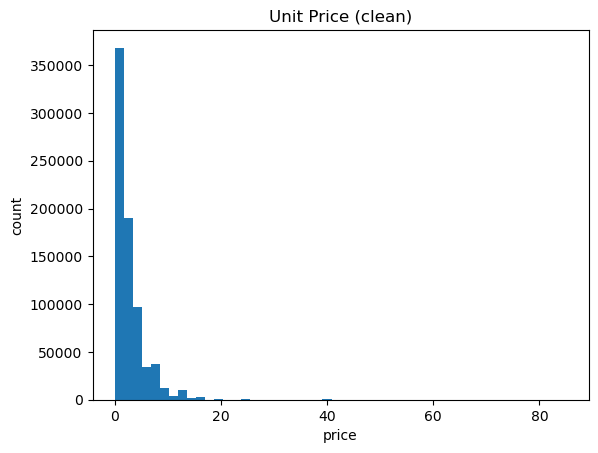

In [9]:
import matplotlib.pyplot as plt
interactions['price'].plot(kind='hist', bins=50, title='Unit Price (clean)')
plt.xlabel('price'); plt.ylabel('count'); plt.show()

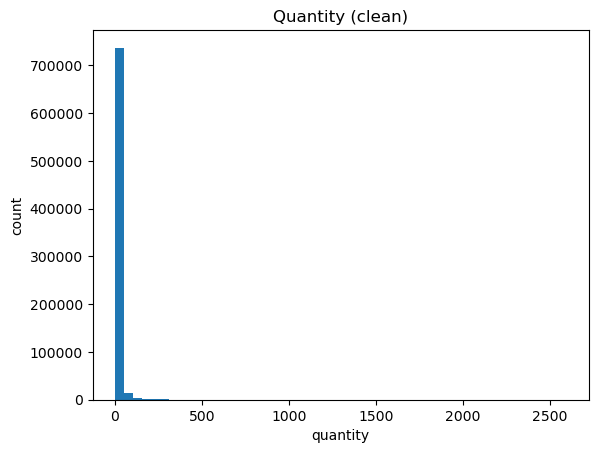

In [10]:
import matplotlib.pyplot as plt
interactions['quantity'].plot(kind='hist', bins=50, title='Quantity (clean)')
plt.xlabel('quantity'); plt.ylabel('count'); plt.show()

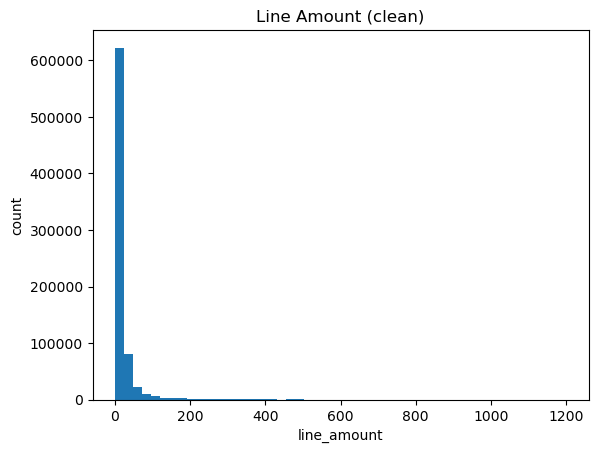

In [11]:
import matplotlib.pyplot as plt
(interactions['line_amount']).plot(kind='hist', bins=50, title='Line Amount (clean)')
plt.xlabel('line_amount'); plt.ylabel('count'); plt.show()

In [12]:
# %% [markdown]
# ## Step 7 — Build user sequences & time-based split (→ train/val/test)

# %%
import pandas as pd, numpy as np
from pathlib import Path

# Inputs from previous steps (or reload if running standalone)
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('./out')
interactions_path = OUT_DIR / 'interactions_clean.parquet'
if 'interactions' not in globals():
    interactions = pd.read_parquet(interactions_path)

# --- Config ---
HIST_MAX      = 30     # cap on history length
MIN_HISTORY   = 2      # require at least this many past items to form a sample
SPLIT_QS      = (0.80, 0.90)  # 80%/10%/10% time split by global timestamps
SAVE_NEGATIVES = False # set True to also save random negatives for quick tests
N_NEG_TRAIN   = 50
N_NEG_VALTEST = 100

# --- Build stable ID maps (will be reused later) ---
items = interactions['stock_code'].astype(str).unique()
item_id_map = pd.DataFrame({'stock_code': items}).sort_values('stock_code').reset_index(drop=True)
item_id_map['item_idx'] = np.arange(len(item_id_map), dtype=np.int64)

customers = interactions['customer_id'].astype('int64').unique()
customer_id_map = pd.DataFrame({'customer_id': customers}).sort_values('customer_id').reset_index(drop=True)
customer_id_map['user_idx'] = np.arange(len(customer_id_map), dtype=np.int64)

# Join indices into interactions (no exotic dtypes)
interactions_idx = (
    interactions
    .merge(item_id_map, on='stock_code', how='left')
    .merge(customer_id_map, on='customer_id', how='left')
    .sort_values(['customer_id','invoice_date'])
    .reset_index(drop=True)
)

# --- Compute global time cutoffs ---
t1 = interactions_idx['invoice_date'].quantile(SPLIT_QS[0])
t2 = interactions_idx['invoice_date'].quantile(SPLIT_QS[1])

def build_sequences(df_user_sorted, t_start, t_end, hist_max=HIST_MAX, min_hist=MIN_HISTORY):
    """Create (history -> next item) samples whose TARGET time is within [t_start, t_end).
       History can include events before t_start to avoid cold history."""
    rows = []
    item_pool = item_id_map['item_idx'].to_numpy()
    for uid, g in df_user_sorted.groupby('customer_id', sort=False):
        items_idx = g['item_idx'].to_numpy()
        times     = g['invoice_date'].to_numpy()
        country   = g['country'].iloc[-1]  # last known country
        for i in range(1, len(items_idx)):
            ts = times[i]
            if not (t_start <= ts < t_end):
                continue
            hist = items_idx[max(0, i - hist_max):i]
            if len(hist) < min_hist:
                continue
            pos  = items_idx[i]
            # store as plain strings to keep Parquet simple/robust
            rows.append((
                uid,
                int(df_user_sorted['user_idx'].iloc[i]),
                ts,
                ' '.join(map(str, hist.tolist())),
                int(pos),
                str(country)
            ))
    if not rows:
        return pd.DataFrame(columns=['customer_id','user_idx','ts','history_idx','pos_item_idx','country'])
    out = pd.DataFrame(rows, columns=['customer_id','user_idx','ts','history_idx','pos_item_idx','country'])
    return out

# Split windows (inclusive start, exclusive end)
t_min = interactions_idx['invoice_date'].min()
t_max = interactions_idx['invoice_date'].max()

seq_train = build_sequences(interactions_idx, t_min, t1)
seq_val   = build_sequences(interactions_idx, t1,   t2)
seq_test  = build_sequences(interactions_idx, t2,   t_max + pd.Timedelta(seconds=1))

# --- (Optional) simple random negatives for quick testing ---
rng = np.random.default_rng(42)
def add_random_negs(df_seq, n_neg):
    if df_seq.empty:
        df_seq['neg_idx'] = ''
        return df_seq
    item_pool = item_id_map['item_idx'].to_numpy()
    negs = []
    for h, pos in zip(df_seq['history_idx'].values, df_seq['pos_item_idx'].values):
        hist_set = set(map(int, h.split())) if h else set()
        forbid   = hist_set | {int(pos)}
        # sample without replacement until we have n_neg or exhaust
        choices = item_pool[~np.isin(item_pool, list(forbid))]
        if len(choices) == 0:
            negs.append('')
            continue
        take = choices[rng.choice(len(choices), size=min(n_neg, len(choices)), replace=False)]
        negs.append(' '.join(map(str, take.tolist())))
    df_seq = df_seq.copy()
    df_seq['neg_idx'] = negs
    return df_seq

if SAVE_NEGATIVES:
    seq_train = add_random_negs(seq_train, N_NEG_TRAIN)
    seq_val   = add_random_negs(seq_val,   N_NEG_VALTEST)
    seq_test  = add_random_negs(seq_test,  N_NEG_VALTEST)

# --- Save artifacts (plain types; Parquet-friendly) ---
OUT_DIR.mkdir(parents=True, exist_ok=True)

def write_parquet_safe(df, path):
    try:
        df.to_parquet(path, index=False, engine='pyarrow')
    except Exception as e:
        print(f"[warn] pyarrow failed on {Path(path).name}: {e}\nFalling back to fastparquet...")
        import fastparquet
        df.to_parquet(path, index=False, engine='fastparquet')

write_parquet_safe(item_id_map,     OUT_DIR / 'item_id_map.parquet')
write_parquet_safe(customer_id_map, OUT_DIR / 'customer_id_map.parquet')
write_parquet_safe(seq_train,       OUT_DIR / 'sequences_train.parquet')
write_parquet_safe(seq_val,         OUT_DIR / 'sequences_val.parquet')
write_parquet_safe(seq_test,        OUT_DIR / 'sequences_test.parquet')

print("✅ Sequences saved:",
      len(seq_train), "train |",
      len(seq_val),   "val |",
      len(seq_test),  "test")
print("Time cuts:", t_min, "→", t1, "→", t2, "→", t_max)
display(seq_train.head(3))


✅ Sequences saved: 597299 train | 75190 val | 75583 test
Time cuts: 2009-12-01 07:45:00 → 2011-09-12 13:41:00 → 2011-11-02 10:40:00 → 2011-12-09 12:50:00


,customer_id,user_idx,ts,history_idx,pos_item_idx,country
0,12346,0,2010-03-02 13:08:00,21 22,23,United Kingdom
1,12346,0,2010-03-02 13:08:00,21 22 23,200,United Kingdom
2,12346,0,2010-03-02 13:08:00,21 22 23 200,203,United Kingdom


In [13]:
from pathlib import Path
import pandas as pd

OUT_DIR = Path(OUT_DIR)  # if OUT_DIR is a string
files = [
    'item_id_map.parquet',
    'customer_id_map.parquet',
    'sequences_train.parquet',
    'sequences_val.parquet',
    'sequences_test.parquet',
]
for f in files:
    p = OUT_DIR / f
    print(f"{f} -> exists={p.exists()} size={p.stat().st_size if p.exists() else 'NA'}")

# Read a small sample using fastparquet to avoid pyarrow registry issues
df_train = pd.read_parquet(OUT_DIR/'sequences_train.parquet', engine='fastparquet')
print(df_train.shape)
print(df_train.head(3))


item_id_map.parquet -> exists=True size=54013
customer_id_map.parquet -> exists=True size=66501
sequences_train.parquet -> exists=True size=12529376
sequences_val.parquet -> exists=True size=1708633
sequences_test.parquet -> exists=True size=1753985
(597298, 6)
   customer_id  user_idx                  ts   history_idx  pos_item_idx  \
0        12346         0 2010-03-02 13:08:00         21 22            23   
1        12346         0 2010-03-02 13:08:00      21 22 23           200   
2        12346         0 2010-03-02 13:08:00  21 22 23 200           203   

          country  
0  United Kingdom  
1  United Kingdom  
2  United Kingdom  
